Plot the SST in the Canary Current Upwelling System.

In [1]:
import sys
sys.path.insert(0, '..')
import os
import glob
from filament import filament
import datetime
import netCDF4
import cmocean
import logging
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from importlib import reload
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="f")
reload(filament)

<module 'filament.filament' from '../filament/filament.py'>

In [2]:
logger = logging.getLogger("filamentPlot")
logger.setLevel(logging.INFO)
logging.info("Starting")
plotvis = 0

In [3]:
datadir = "/data/SST/CapeGhir/2plot/"
datadir = "/data/OceanColor/"
figdir = "../figures/SST/"
figdir2 = "/data/SST/CapeGhir/figures/medium"
visibledir = "/data/Visible/"
datafilelist = sorted(glob.glob(os.path.join(datadir, "*20200619*.nc")))
nfiles = len(datafilelist)
logger.info("Processing {} files".format(nfiles))
mediumdomain = (-19., -6., 25., 35.)
smalldomain = (-15., -9., 27., 33.)
tinydomain = (-12., -9., 29.5, 32.)
canarydomain = (-18.5, -13., 25., 29.5)

INFO:filamentPlot:Processing 3 files


In [4]:
if not(os.path.exists(figdir)):
    os.makedirs(figdir)
if not(os.path.exists(figdir2)):
    os.makedirs(figdir2)

## Using Cartopy

In [5]:
datafilelist = ["/data/OceanColor/SNPP_VIIRS.20200714T142401.L2.SST.NRT.nc"]
visiblefile = "/data/Visible/VIIRS-2020-06-03T00_00_00Z.tiff"
os.path.isfile(visiblefile)
vis = filament.Visible()
vis.read_geotiff(visiblefile)

INFO:filamentPlot:Working on /data/OceanColor/SNPP_VIIRS.20200714T142401.L2.SST.NRT.nc
INFO:filamentPlot:Level-2 data


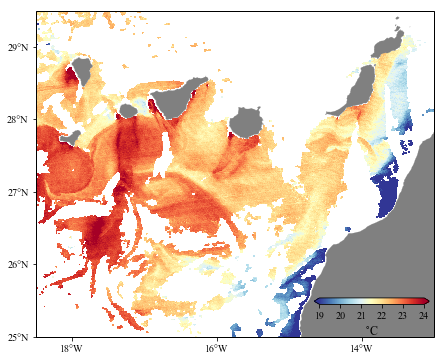

In [7]:
for datafile in datafilelist:
    logger.info("Working on {}".format(datafile))
    with netCDF4.Dataset(datafile) as nc:
        proclevel = nc.processing_level
    sst = filament.SST()
    
    # Select the reader according to processing level
    if proclevel == "L3 Mapped":
        logger.info("Level-3 data")
        sst.read_from_oceancolorL3(datafile, coordinates)
    elif proclevel == "L2":
        logger.info("Level-2 data")
        sst.read_from_oceancolorL2(datafile)
        sst.field = np.ma.masked_where(sst.qflag > 2, sst.field)
        
    figname = os.path.join(figdir, sst.get_figname())

    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, projection=myproj)
    #vis.add_to_plot(ax, myproj)
    #sst.field[sst.lat.data == -999.] = np.nan
    #sst.field[sst.lon.data == -999.] = np.nan
    #sst.lat[sst.lat.data == -999.] = np.nan
    #sst.lon[sst.lon.data == -999.] = np.nan
    
    #sst.lat = np.ma.masked_equal(sst.lat, -999.0, copy=True)
    #sst.lon = np.ma.masked_equal(sst.lon, -999.0, copy=True)
    sst.add_to_plot(fig, ax, domain=tinydomain, cmap=plt.cm.RdYlBu_r,
                    clim=[19., 24.], vis=False,
                    cbarloc=[0.65, 0.2, 0.2, 0.015], alpha=1)
    
    ax.add_feature(coast, linewidth=.2, color=".5")
    filament.decorate_map(ax, canarydomain, np.arange(-20., -10., 2.), 
                              np.arange(25., 32., 1.))
    plt.savefig(figname, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

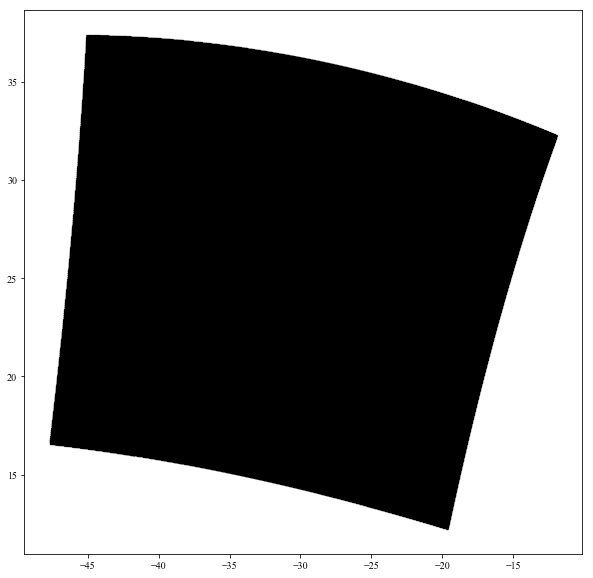

In [34]:
ssttest = filament.SST()
ssttest.read_from_oceancolorL2("/data/OceanColor/AQUA_MODIS.20200506T135501.L2.SST.NRT.nc")
ssttest.lat.min()

plt.figure(figsize=(10, 10))
plt.plot(sst.lon, sst.lat, "ko", ms=.1)
plt.show()

## GHRSST

In [7]:
datadir2 = "/data/SST/GHRSST/"
datafilelist2 = sorted(glob.glob(os.path.join(datadir2, "20170904*.nc")))
nfiles = len(datafilelist2)
logger.info("Processing {} files".format(nfiles))

INFO:filamentPlot:Processing 1 files


In [8]:
for datafile in datafilelist2:
    logger.info(datafile)
    sst = filament.SST()
    sst.read_from_ghrsst(datafile)
    sst.field = np.ma.masked_where(sst.qflag != 5, sst.field)
    
    # Plot without visible
    figname = os.path.join(figdir, sst.get_figname())
    sst.make_plot2(m, figname=figname)
    
    # With visible image background
    visiblefile = os.path.join(visibledir, "VIIRS_{}.tiff".format(sst.date.strftime("%Y%m%d")))
    if os.path.exists(visiblefile):
        visibleim = filament.Visible()
        visibleim.read_from(visiblefile)
        visibleim.extract_area(coordinates)
    figname = os.path.join(figdir, "_".join((sst.get_figname(), "visible")))
    sst.make_plot2(m, figname=figname, visibleim=visibleim)
    
    # With visible image background and SWOT
    swot = filament.Swot()
    swot.read_from(swotfile)
    swot.select_domain(coordinates)
    visiblefile = os.path.join(visibledir, "VIIRS_{}.tiff".format(sst.date.strftime("%Y%m%d")))
    if os.path.exists(visiblefile):
        visibleim = filament.Visible()
        visibleim.read_from(visiblefile)
        visibleim.extract_area(coordinates)
    figname = os.path.join(figdir, "_".join((sst.get_figname(), "visible", "swot")))
    sst.make_plot2(m, figname=figname, visibleim=visibleim, swot=swot)

INFO:filamentPlot:/data/SST/GHRSST/20170904140000-OSPO-L2P_GHRSST-SSTskin-VIIRS_NPP-ACSPO_V2.40-v02.0-fv01.0.nc


TypeError: '>=' not supported between instances of 'NoneType' and 'float'